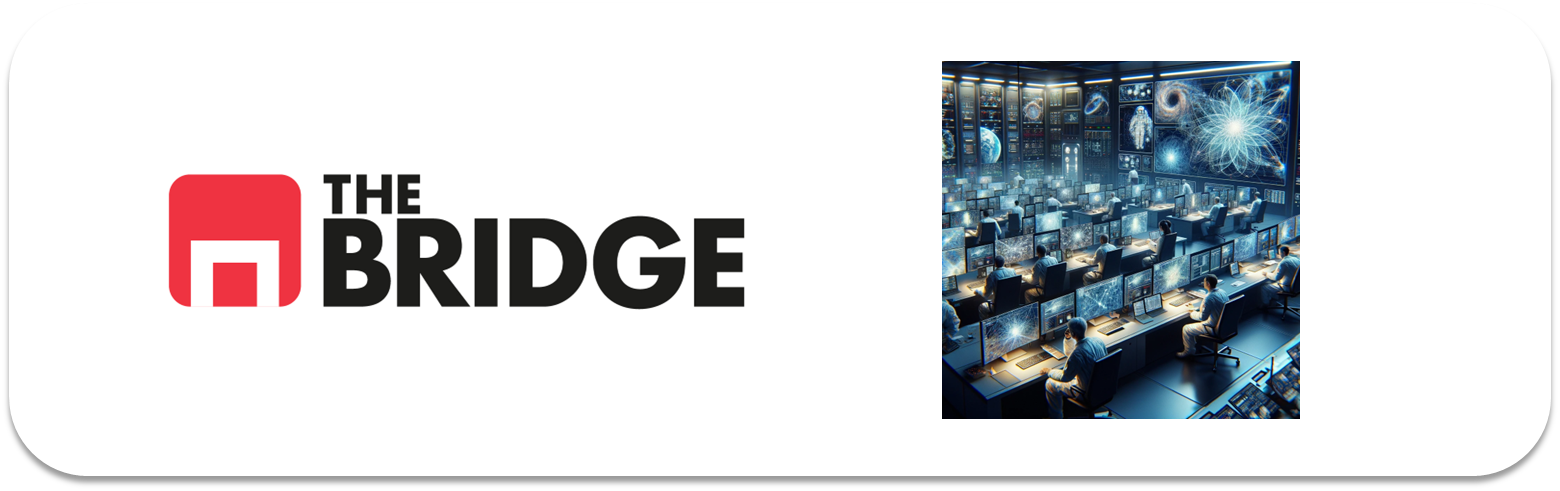

## PRACTICA OBLIGATORIA: **Transfer Learning y Fine Tuning**

* La práctica obligatoria de esta unidad consiste en un repetir el ejercicio de construcción de un modelo de clasificación de paisajes pero usando un modelo preentrenado. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from skimage.io import imread
import cv2
from sklearn.metrics import classification_report, confusion_matrix

2024-03-14 18:21:01.366904: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior.


### Se pide

1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

3. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

4. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

5. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

EXTRA:
- Repetir el transfer learning empleando aumentado de imágenes.



In [2]:
df = pd.read_csv("./data/mnist_clase_convo.csv")

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 125.8 MB


In [4]:
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
ROOT_PATH = './data/'
TRAIN_PATH = ROOT_PATH + "seg_train/"
TEST_PATH = ROOT_PATH + "seg_test/"

In [4]:
def read_data(directorio, reshape_dim=(160, 160)):
    X = []
    y = []
    for folder in os.listdir(directorio):
        print(folder)
        if os.path.isdir(os.path.join(directorio, folder)):
            for file in os.listdir(os.path.join(directorio, folder)):

                image_path = os.path.join(directorio, folder, file)
                image = imread(image_path)
                image_resized = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 160x160

                X.append(image_resized)
                y.append(folder)

    return np.array(X), np.array(y)


In [5]:
X_train,y_train = read_data(TRAIN_PATH)
X_test, y_test = read_data(TEST_PATH)

forest
buildings
glacier
street
mountain
sea
forest
buildings
glacier
street
mountain
sea


In [6]:
# Convertir etiquetas de texto a enteros, luego a formato one-hot
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

y_train_one_hot = to_categorical(y_train_encoded, num_classes=6)
y_test_one_hot = to_categorical(y_test_encoded, num_classes=6)

In [7]:
print('X train shape: ', X_train.shape)
print('Y train shape: ', y_train.shape)

X train shape:  (14034, 160, 160, 3)
Y train shape:  (14034,)


In [8]:
print('X train shape: ', X_test.shape)
print('Y train shape: ', y_test.shape)

X train shape:  (3000, 160, 160, 3)
Y train shape:  (3000,)


In [9]:
def show_images_batch(paisajes, names = [], n_cols = 5, size_scale = 2):
    n_rows = ((len(paisajes) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, paisaje in enumerate(paisajes):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(paisaje, cmap = "Greys")
        plt.axis("off")
        if len(names):
            plt.title(names[index])

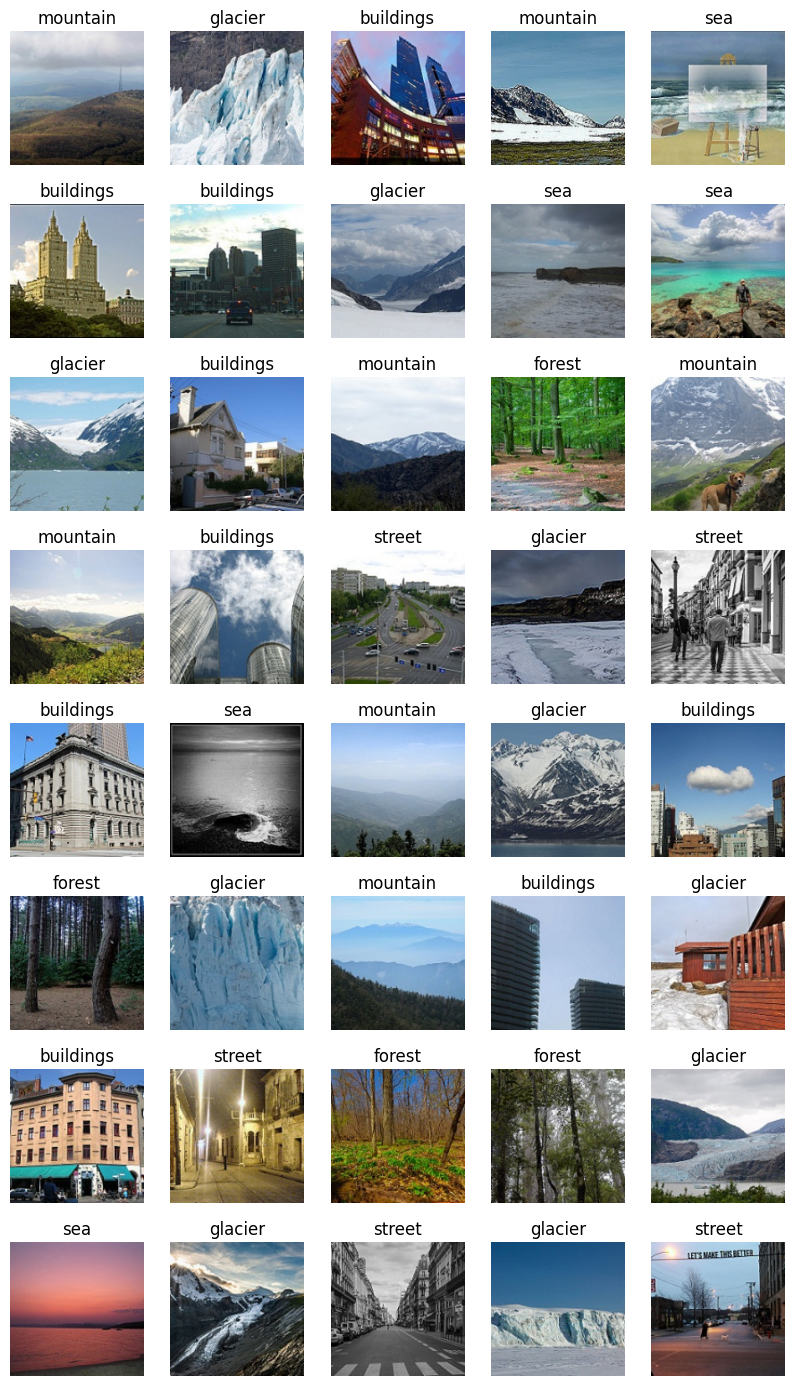

In [27]:
indices = np.random.randint(0,len(X_train),40)
show_images_batch(X_train[indices], names = y_train[indices], n_cols = 5)

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.
3. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.


In [11]:
# cabeza
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(160, 160, 3)) # imágenes previamente redimendionadas 

In [13]:
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# TRANSFER LEARNING


# Añadir nueva cabeza al modelo (capas personalizadas)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Primera capa densa oculta
x = Dense(512, activation='relu')(x)   # Segunda capa densa oculta
predictions = Dense(6, activation='softmax')(x)  # Capa de salida para 6 clases

#  modelo a entrenar
model = Model(inputs=base_model.input, outputs=predictions)

# Primero, congelamos todas las capas del modelo base de MobileNetV2
for layer in base_model.layers:
    layer.trainable = False

# Compilamos el modelo (deberíamos hacerlo después de configurar las capas como no entrenables)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Definición de los generadores de datos con aumento de datos para el conjunto de entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalización de los pixeles al rango 0-1
    rotation_range=20,  # Rotación aleatoria de las imágenes hasta 20 grados
    width_shift_range=0.2,  # Desplazamiento horizontal aleatorio
    height_shift_range=0.2,  # Desplazamiento vertical aleatorio
    horizontal_flip=True  # Volteo horizontal aleatorio
)

# Solo normalización para el conjunto de test, sin aumento de datos
test_datagen = ImageDataGenerator(
    rescale=1./255  # Normalización de los pixeles al rango 0-1
)

# Entrenamiento (utilizando los generadores de datos y el método fit)

history = model.fit(train_datagen.flow(X_train, y_train_one_hot, batch_size=32),
                    validation_data=test_datagen.flow(X_test, y_test_one_hot),
                    steps_per_epoch=len(X_train) / 32,
                    validation_steps=len(X_test) / 32,
                    epochs=10)

# Evaluación del modelo en el conjunto de test
test_loss, test_acc = model.evaluate(test_datagen.flow(X_test, y_test_one_hot), steps=len(X_test) / 32)
print("Test accuracy: ", test_acc)
print("Test loss: ", test_loss)

# Predicciones en el conjunto de test para reporte de clasificación y matriz de confusión
y_pred = model.predict(test_datagen.flow(X_test, batch_size=32), steps=len(X_test) / 32)
y_pred_classes = np.argmax(y_pred, axis=1)

# Verdaderas etiquetas de y_test
y_true = np.argmax(y_test_one_hot, axis=1)

# Reporte de clasificación
print("Classification Report:\n", classification_report(y_true, y_pred_classes))

# Matriz de confusión
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred_classes))



Epoch 1/10
438/438 [==============================] - 134s 299ms/step - loss: 0.4299 - accuracy: 0.8479 - val_loss: 0.2630 - val_accuracy: 0.9060
Epoch 2/10
438/438 [==============================] - 133s 302ms/step - loss: 0.3219 - accuracy: 0.8821 - val_loss: 0.2624 - val_accuracy: 0.9017
Epoch 3/10
438/438 [==============================] - 133s 303ms/step - loss: 0.2980 - accuracy: 0.8909 - val_loss: 0.3103 - val_accuracy: 0.8890
Epoch 4/10
438/438 [==============================] - 134s 305ms/step - loss: 0.2827 - accuracy: 0.8932 - val_loss: 0.2417 - val_accuracy: 0.9110
Epoch 5/10
438/438 [==============================] - 133s 303ms/step - loss: 0.2633 - accuracy: 0.9039 - val_loss: 0.2425 - val_accuracy: 0.9070
Epoch 6/10
438/438 [==============================] - 133s 302ms/step - loss: 0.2588 - accuracy: 0.9029 - val_loss: 0.2316 - val_accuracy: 0.9113
Epoch 7/10
438/438 [==============================] - 139s 317ms/step - loss: 0.2443 - accuracy: 0.9095 - val_loss: 0.2266 -

4. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

In [14]:
# Descongelamos las últimas 10 capas
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Es crucial utilizar un ritmo de aprendizaje muy bajo para el fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])


In [15]:
# Continuamos el entrenamiento para el fine-tuning
fine_tune_epochs = 10
total_epochs = 10 + fine_tune_epochs

history_fine = model.fit(train_datagen.flow(X_train, y_train_one_hot, batch_size=32),
                         steps_per_epoch=len(X_train) / 32,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=test_datagen.flow(X_test, y_test_one_hot),
                         validation_steps=len(X_test) / 32)


Epoch 10/20
438/438 [==============================] - 156s 348ms/step - loss: 0.3376 - accuracy: 0.8735 - val_loss: 0.2665 - val_accuracy: 0.9003
Epoch 11/20
438/438 [==============================] - 151s 344ms/step - loss: 0.2826 - accuracy: 0.8937 - val_loss: 0.2522 - val_accuracy: 0.9057
Epoch 12/20
438/438 [==============================] - 153s 349ms/step - loss: 0.2667 - accuracy: 0.8995 - val_loss: 0.2347 - val_accuracy: 0.9120
Epoch 13/20
438/438 [==============================] - 153s 349ms/step - loss: 0.2549 - accuracy: 0.9025 - val_loss: 0.2278 - val_accuracy: 0.9163
Epoch 14/20
438/438 [==============================] - 155s 354ms/step - loss: 0.2463 - accuracy: 0.9080 - val_loss: 0.2234 - val_accuracy: 0.9150
Epoch 15/20
438/438 [==============================] - 153s 350ms/step - loss: 0.2451 - accuracy: 0.9081 - val_loss: 0.2214 - val_accuracy: 0.9167
Epoch 16/20
438/438 [==============================] - 158s 361ms/step - loss: 0.2278 - accuracy: 0.9131 - val_loss: 0

In [16]:
# Evaluación del modelo en el conjunto de test después del fine-tuning
test_loss, test_acc = model.evaluate(test_datagen.flow(X_test, y_test_one_hot), steps=len(X_test) / 32)
print("Post Fine-tuning - Test accuracy: ", test_acc)
print("Post Fine-tuning - Test loss: ", test_loss)

# Predicciones en el conjunto de test para reporte de clasificación y matriz de confusión después del fine-tuning
y_pred_fine = model.predict(test_datagen.flow(X_test, batch_size=32), steps=len(X_test) / 32)
y_pred_classes_fine = np.argmax(y_pred_fine, axis=1)

# Reporte de clasificación después del fine-tuning
print("Post Fine-tuning - Classification Report:\n", classification_report(y_true, y_pred_classes_fine))

# Matriz de confusión después del fine-tuning
print("Post Fine-tuning - Confusion Matrix:\n", confusion_matrix(y_true, y_pred_classes_fine))


93/93 [==============================] - 22s 230ms/step - loss: 0.2216 - accuracy: 0.9187
Post Fine-tuning - Test accuracy:  0.918666660785675
Post Fine-tuning - Test loss:  0.2216331511735916
93/93 [==============================] - 23s 236ms/step
Post Fine-tuning - Classification Report:
               precision    recall  f1-score   support

           0       0.15      0.14      0.15       437
           1       0.14      0.14      0.14       474
           2       0.18      0.16      0.17       553
           3       0.16      0.17      0.17       525
           4       0.17      0.17      0.17       510
           5       0.19      0.20      0.20       501

    accuracy                           0.17      3000
   macro avg       0.16      0.16      0.16      3000
weighted avg       0.17      0.17      0.17      3000

Post Fine-tuning - Confusion Matrix:
 [[ 63  70  58  91  72  83]
 [ 60  65  94  98  72  85]
 [ 71  91  89 101 114  87]
 [ 83  84  88  90  98  82]
 [ 77  87  87  89  

5. Comparar métricas antes y después del fine tuning

In [17]:
# Almacenar la precisión y pérdida de validación de la última época antes del fine-tuning
pre_ft_val_accuracy = history.history['val_accuracy'][-1]
pre_ft_val_loss = history.history['val_loss'][-1]


In [18]:
# Evaluar el modelo después del fine-tuning
post_ft_val_loss, post_ft_val_accuracy = model.evaluate(test_datagen.flow(X_test, y_test_one_hot), steps=len(X_test) / 32)

# Nota: Los valores de post_ft_val_loss y post_ft_val_accuracy se almacenan directamente desde la evaluación


93/93 [==============================] - 23s 246ms/step - loss: 0.2216 - accuracy: 0.9187


In [20]:

# DF para comparar métricas antes y después del fine tuning
metrics_comparison = pd.DataFrame({
    "Metric": ["Accuracy", "Loss"],
    "Before Fine-Tuning": [pre_ft_val_accuracy, pre_ft_val_loss],
    "After Fine-Tuning": [post_ft_val_accuracy, post_ft_val_loss]
})

# Establecer la columna "Metric" como índice para mejorar la visualización
metrics_comparison.set_index("Metric", inplace=True)

metrics_comparison


,Before Fine-Tuning,After Fine-Tuning
Metric,,
Accuracy,0.908000,0.918667
Loss,0.233504,0.221633


In [23]:

# Calcula las matrices de confusión antes y después del fine-tuning
conf_mat_pre_ft = confusion_matrix(y_true, y_pred_classes)
conf_mat_post_ft = confusion_matrix(y_true, y_pred_classes_fine)


In [24]:

class_names = label_encoder.classes_
print("Nombres de las clases:", class_names)


Nombres de las clases: ['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']


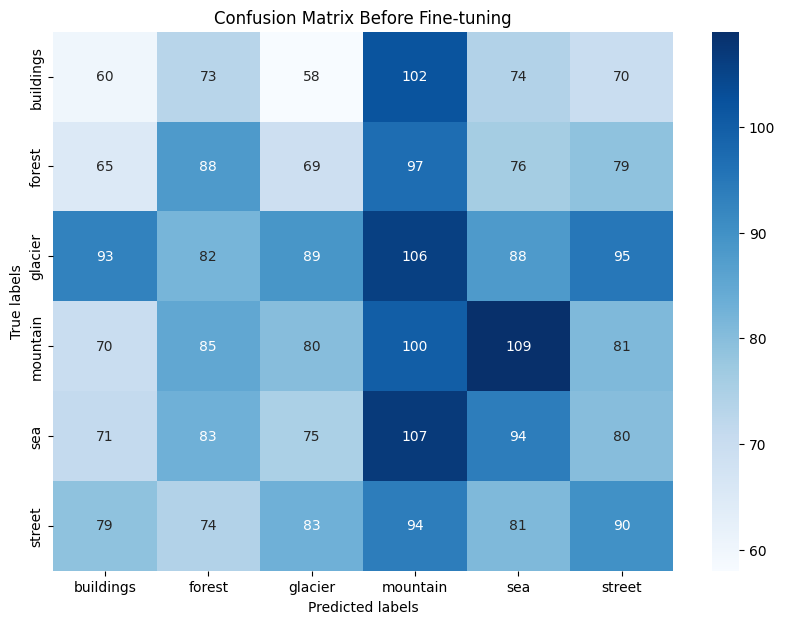

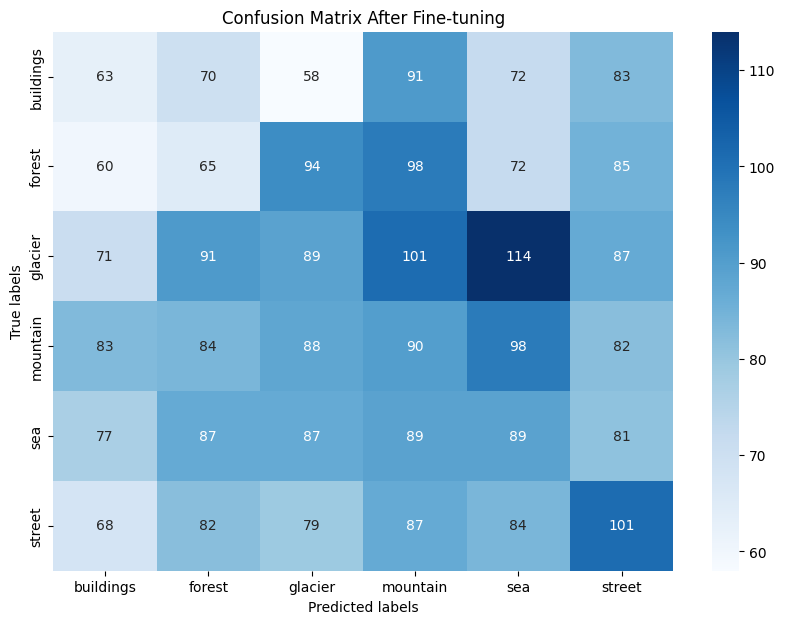

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Nombres reales de las clases
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Asumiendo que conf_mat_pre_ft es tu matriz de confusión antes del fine-tuning
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat_pre_ft, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix Before Fine-tuning')
plt.show()

# Asumiendo que conf_mat_post_ft es tu matriz de confusión después del fine-tuning
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat_post_ft, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix After Fine-tuning')
plt.show()


In [ ]:
'''
ANÁLISIS CHAT GPT --> RECAP DE CONTEXTO Y MODELO

Modelo Utilizado: MobileNetV2
MobileNetV2 es un modelo de red neuronal convolucional diseñado para ser eficiente en términos de computación. 
Esto significa que puede funcionar bien incluso en dispositivos con recursos limitados, como teléfonos móviles o computadoras menos potentes. 
A pesar de su eficiencia, es bastante bueno para tareas de visión por computadora como la clasificación de imágenes.

Transfer Learning y Fine-Tuning
El modelo ha sido preentrenado en un conjunto de datos muy grande llamado ImageNet, 
que contiene millones de imágenes en miles de categorías. Por lo tanto, ya sabe mucho sobre diferentes características visuales que pueden 
ser comunes a muchas tareas de visión por computadora.

Para nuestro problema específico, que es la clasificación de paisajes, no empezamos desde cero. 
En lugar de eso, tomamos este modelo MobileNetV2 ya entrenado y lo adaptamos a nuestro conjunto de datos más pequeño de imágenes de paisajes. 
Esto es lo que llamamos transfer learning, que es muy útil porque nos ahorra mucho tiempo y recursos computacionales.

Hiperparámetros
 Algunos de los hiperparámetros que hemos configurado incluyen:

- Tamaño de las Imágenes: Las imágenes se redimensionaron a 160x160 píxeles para coincidir con lo que MobileNetV2 espera.

- Ritmo de Aprendizaje: Esto determina cuánto cambian los pesos del modelo con cada actualización durante el entrenamiento. 
Un ritmo de aprendizaje bajo ayuda a hacer ajustes finos sin sobrepasar el aprendizaje anterior.

- Épocas: El número de veces que el modelo pasa por todo el conjunto de entrenamiento. Más épocas significan más oportunidades de aprendizaje, pero también más tiempo y recursos utilizados.

¿Por Qué es Útil para Este Problema?
Este enfoque es útil porque nos permite aprovechar un modelo avanzado sin tener que construirlo y entrenarlo desde cero, 
lo cual sería mucho más costoso. Además, ajustar un modelo preentrenado hace que sea más rápido obtener resultados buenos, 
especialmente cuando nuestro conjunto de datos es más pequeño en comparación con el utilizado para entrenar MobileNetV2 originalmente.

En resumen, MobileNetV2 y las técnicas de transfer learning y fine-tuning son útiles porque nos permiten crear un modelo de clasificación 
de imágenes muy competente en menos tiempo y con menos datos, lo que es ideal cuando no tenemos recursos de cómputo masivos o 
una gran cantidad de imágenes etiquetadas para entrenar nuestro modelo desde cero.
'''

In [ ]:
'''
ANÁLISIS CHAT GPT --> INFORME DE RESULTADOS

Contexto: Se implementó un modelo de red neuronal convolucional utilizando la técnica de transfer learning con MobileNetV2, 
seguido de un proceso de fine-tuning, para clasificar imágenes de paisajes en seis categorías diferentes: edificios, bosques, glaciares, montañas, mar y calles.

Proceso Inicial de Aprendizaje:
En la fase inicial de transfer learning sin fine-tuning, el modelo alcanzó una precisión de prueba del 90.80% y una pérdida de 0.2335. 
La matriz de confusión correspondiente revela un rendimiento razonablemente bueno con ciertas confusiones entre clases. 
Por ejemplo, las imágenes de glaciares y montañas parecían ser las más desafiantes para el modelo, con una cantidad significativa de clasificaciones incorrectas.

Proceso de Fine-Tuning:
Después de aplicar el fine-tuning, que ajusta los pesos de las últimas capas del modelo preentrenado junto con las capas personalizadas añadidas, 
la precisión de prueba mejoró al 91.87% y la pérdida disminuyó a 0.2216. 
Esta mejora en la precisión y la reducción en la pérdida sugieren que el fine-tuning permitió que el modelo se adaptara mejor a las especificidades del conjunto de datos.

La matriz de confusión post fine-tuning muestra una distribución más uniforme de las predicciones, 
con una ligera mejora en la precisión de clasificación entre categorías similares. Sin embargo, 
las confusiones entre clases similares todavía están presentes, lo que indica áreas para posibles mejoras futuras.

Conclusiones Principales:

- Mejora en la Precisión: El proceso de fine-tuning ha mejorado la precisión del modelo, lo cual es un indicador positivo de que 
el modelo ha aprendido características más discriminativas de cada categoría después de ajustar los pesos de las capas del modelo base.

- Reducción de la Pérdida: La disminución en la pérdida del modelo sugiere que el modelo 
está más seguro de sus predicciones después del fine-tuning, lo que podría traducirse en un mejor rendimiento en la clasificación de nuevas imágenes.

- Confusiones Persistentes: A pesar de la mejora, hay clases que continuamente se confunden entre sí. 
Esto podría ser un punto focal para la mejora, posiblemente a través de un preprocesamiento mejorado, aumentando el conjunto de datos o ajustando más finamente el modelo.


En resumen, el modelo ha mostrado una mejora significativa en la precisión y en la pérdida después del fine-tuning, 
lo que demuestra la efectividad de esta técnica para la tarea de clasificación de imágenes. No obstante, se identificaron oportunidades para futuras optimizaciones que podrían llevar a un modelo aún más robusto y preciso.
'''